In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import h5py
from dataset.MatDataset import JHTDB_RECTANGULAR
from models.encoder import *
from models.classifier import *

In [30]:
dataset = JHTDB_RECTANGULAR(root='data/jhtdb_transition_bl', tstart=1, tend=10, fields='u', dataset='transition_bl', partition=True, sub_size=14)
full_sample_ = dataset.get_one_full_sample(100)

In [31]:
full_sample = full_sample_[1]
full_sample_recon = full_sample_[0]


In [32]:
idx1 = 320
idx2 = 1000
idx3 = 185050
sub_sample_0 = full_sample[idx1].squeeze()
sub_sample_1 = full_sample[idx2].squeeze()
sub_sample_2 = full_sample[idx3].squeeze()

num_partiton_dim_x = full_sample_recon.shape[1] - sub_sample_0.shape[1] + 1
num_partiton_dim_y = full_sample_recon.shape[0] - sub_sample_0.shape[1] + 1
print(num_partiton_dim_x, num_partiton_dim_y)

3302 206


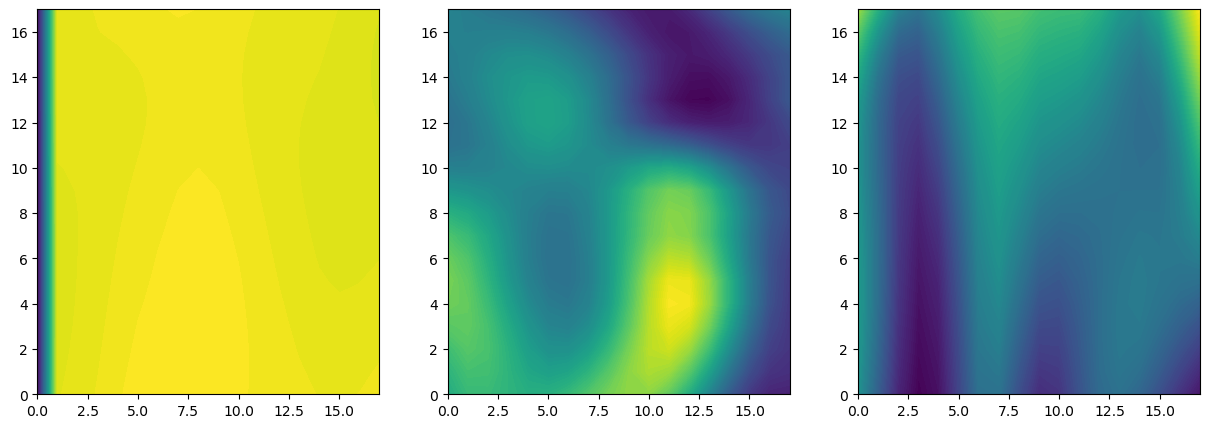

In [33]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(sub_sample_0, levels=100)
ax[1].contourf(sub_sample_1, levels=100)
ax[2].contourf(sub_sample_2, levels=100)

(114, 1) (176, 4) (62, 898)


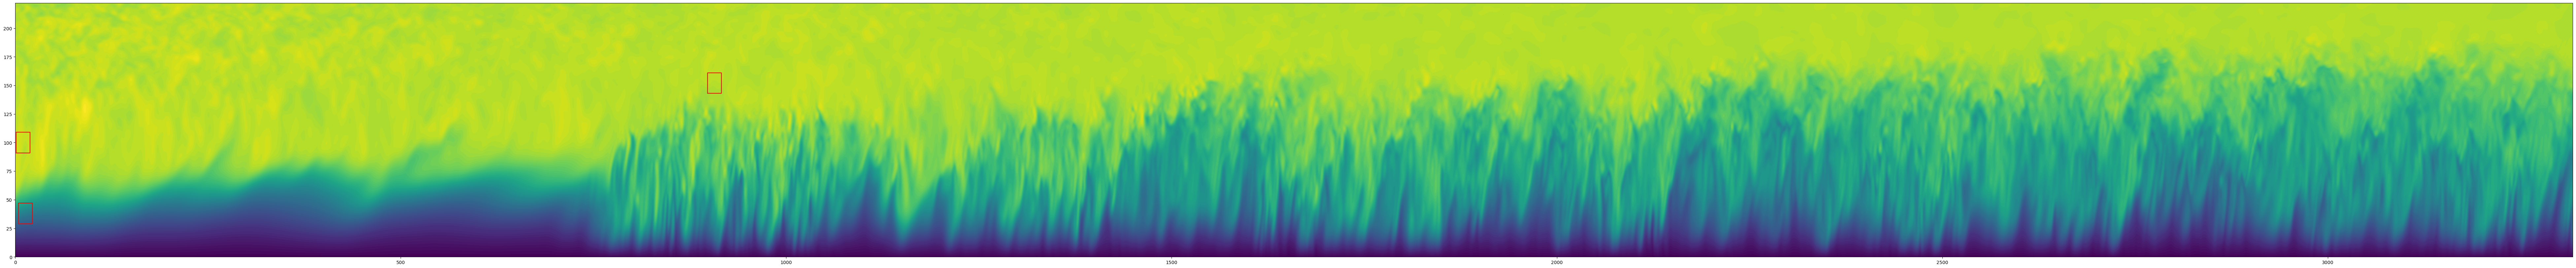

In [34]:
# plot the full sample with red box marking the sub sample location
plt.figure(figsize=(100, 10))
plt.contourf(full_sample_recon.squeeze(), levels=100)
sample_0_loc = (idx1 % num_partiton_dim_y, idx1 // num_partiton_dim_y)
sample_1_loc = (idx2 % num_partiton_dim_y, idx2 // num_partiton_dim_y)
sample_2_loc = (idx3 % num_partiton_dim_y, idx3 // num_partiton_dim_y)
print(sample_0_loc, sample_1_loc, sample_2_loc)

# reverse x axis dur to the way the image is plotted
sample_0_loc = (full_sample_recon.shape[0] - sample_0_loc[0] - sub_sample_0.shape[0], sample_0_loc[1])
sample_1_loc = (full_sample_recon.shape[0] - sample_1_loc[0] - sub_sample_1.shape[0], sample_1_loc[1])
sample_2_loc = (full_sample_recon.shape[0] - sample_2_loc[0] - sub_sample_2.shape[0], sample_2_loc[1])

plt.plot([sample_0_loc[1], sample_0_loc[1] + sub_sample_0.shape[1], sample_0_loc[1] + sub_sample_0.shape[1], sample_0_loc[1], sample_0_loc[1]], [sample_0_loc[0], sample_0_loc[0], sample_0_loc[0] + sub_sample_0.shape[0], sample_0_loc[0] + sub_sample_0.shape[0], sample_0_loc[0]], 'r')
plt.plot([sample_1_loc[1], sample_1_loc[1] + sub_sample_1.shape[1], sample_1_loc[1] + sub_sample_1.shape[1], sample_1_loc[1], sample_1_loc[1]], [sample_1_loc[0], sample_1_loc[0], sample_1_loc[0] + sub_sample_1.shape[0], sample_1_loc[0] + sub_sample_1.shape[0], sample_1_loc[0]], 'r')
plt.plot([sample_2_loc[1], sample_2_loc[1] + sub_sample_2.shape[1], sample_2_loc[1] + sub_sample_2.shape[1], sample_2_loc[1], sample_2_loc[1]], [sample_2_loc[0], sample_2_loc[0], sample_2_loc[0] + sub_sample_2.shape[0], sample_2_loc[0] + sub_sample_2.shape[0], sample_2_loc[0]], 'r') 


In [35]:
from models.encoder import SpectrumEncoder

encoder = SpectrumEncoder(n_components=10, domain_size=14)
tke_spectrum_0 = encoder._compute_tke_spectrum([sub_sample_0, 0.1963495, 0.1963495])
tke_spectrum_1 = encoder._compute_tke_spectrum([sub_sample_1, 0.1963495, 0.1963495])
tke_spectrum_2 = encoder._compute_tke_spectrum([sub_sample_2, 0.1963495, 0.1963495])

d:\Work\research\ARRS\models\encoder.py:227: RuntimeWarning: divide by zero encountered in log
  return np.log(tke_spectrum[1:])


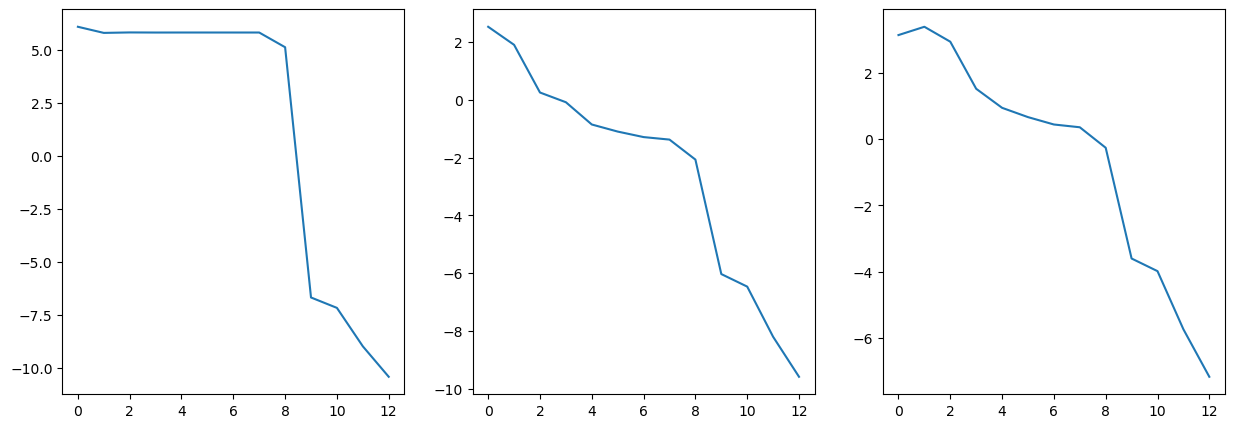

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(tke_spectrum_0)
ax[1].plot(tke_spectrum_1)
ax[2].plot(tke_spectrum_2)

In [37]:
latent_space = encoder.get_latent_space(full_sample)
print(np.max(latent_space), np.min(latent_space))
classifier2 = KMeansClassifier(n_clusters=3)
classifier2.train(latent_space)
pred = classifier2.cluster(latent_space)
print(pred[idx1], pred[idx2], pred[idx3])

1.869337827237581 -18.420680743952367
0 0 0


In [38]:

classifier = KMeansWasserstein(n_clusters=3)
classifier.fit(latent_space)
pred = classifier.predict(latent_space)
print(pred[idx1], pred[idx2], pred[idx3])


0 0 0


309427 96402 288431


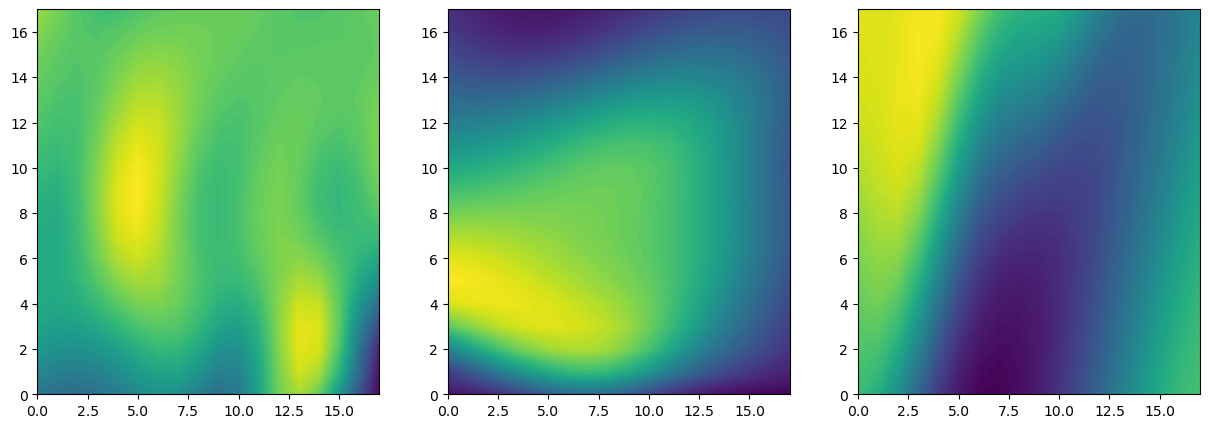

In [49]:
# locate label 1 samples and label 2 samples
label_0_loc = np.where(pred == 0)
label_1_loc = np.where(pred == 1)
label_2_loc = np.where(pred == 2)

print(len(label_0_loc[0]), len(label_1_loc[0]), len(label_2_loc[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(full_sample[label_0_loc[0][300000]].squeeze(), levels=100)
ax[1].contourf(full_sample[label_1_loc[0][95000]].squeeze(), levels=100)
ax[2].contourf(full_sample[label_2_loc[0][288000]].squeeze(), levels=100)

plt.show()

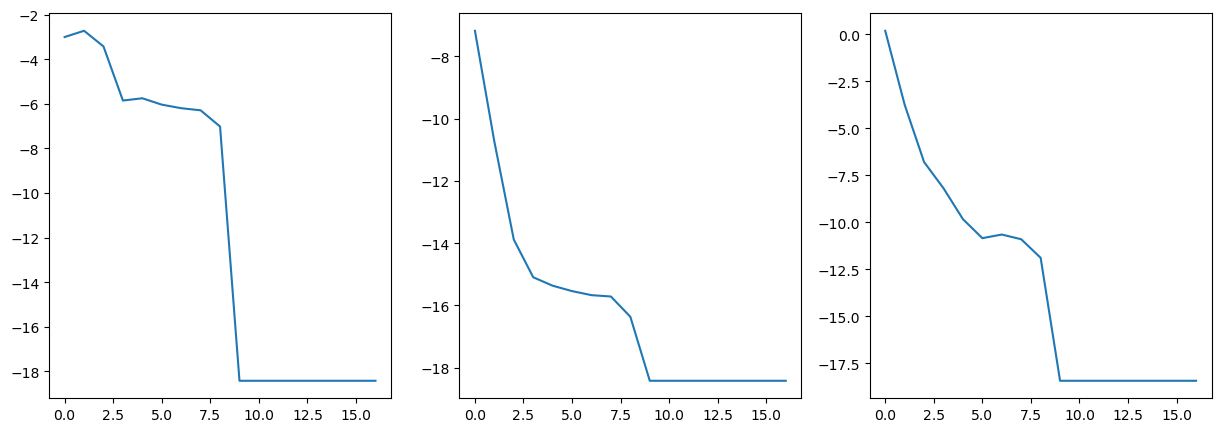

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(latent_space[label_0_loc[0][300000]])
ax[1].plot(latent_space[label_1_loc[0][95000]])
ax[2].plot(latent_space[label_2_loc[0][288000]])